### Classifying and predicting early hospital readmissions:

Classifying with supervised learning whether diabetic patients are readmitted, and if they are, if it's before or after 30 days.

Using the dataset from here: https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008

In [75]:
import pandas as pd
import seaborn as sns
import pickle
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesClassifier

# eventually relocated to plots.py:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix

In [76]:
df = pd.read_csv('diabetic_data.csv')

In [77]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


#### Age and weight should be numeric, not object - weight and age are both given as ranges rather than a discrete value
#### Also No and Yes should be changed to 0 and 1

In [78]:
# Replace age ranges with numerical values:
age_id = {'[0-10)':0, 
        '[10-20)':10, 
        '[20-30)':20, 
        '[30-40)':30, 
        '[40-50)':40, 
        '[50-60)':50,
        '[60-70)':60, 
        '[70-80)':70, 
        '[80-90)':80, 
        '[90-100)':90}
df['age'] = df.age.replace(age_id)

In [79]:
df.weight.unique()

array(['?', '[75-100)', '[50-75)', '[0-25)', '[100-125)', '[25-50)',
       '[125-150)', '[175-200)', '[150-175)', '>200'], dtype=object)

In [80]:
# Replace weight ranges with numerical values:
# These are mostly missing values, so the other idea is we could just code whether missing or not
# We could one-hot encode them instead also, but they're mostly missing
# Assigning the missing value to 0 in this label encoding is a bit flawed, but might work fine
weight_dict = {'?':0, 
               '[75-100)':100, 
               '[50-75)':75, 
               '[0-25)':25, 
               '[100-125)':125, 
               '[25-50)':50,
               '[125-150)':150, 
               '[175-200)':200, 
               '[150-175)':175, 
               '>200':225}
df['weight'] = df.weight.replace(weight_dict)

In [81]:
df.weight.unique()

array([  0, 100,  75,  25, 125,  50, 150, 200, 175, 225])

In [82]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,0,0,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,10,0,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,20,0,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,30,0,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,40,0,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [83]:
df.shape

(101766, 50)

In [84]:
df.describe()

,encounter_id,patient_nbr,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses
count,1.017660e+05,1.017660e+05,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000,101766.000000
mean,1.652016e+08,5.433040e+07,60.967022,3.103198,2.024006,3.715642,5.754437,4.395987,43.095641,1.339730,16.021844,0.369357,0.197836,0.635566,7.422607
std,1.026403e+08,3.869636e+07,15.940838,17.840471,1.445403,5.280166,4.064081,2.985108,19.674362,1.705807,8.127566,1.267265,0.930472,1.262863,1.933600
min,1.252200e+04,1.350000e+02,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000
25%,8.496119e+07,2.341322e+07,50.000000,0.000000,1.000000,1.000000,1.000000,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000,6.000000
50%,1.523890e+08,4.550514e+07,60.000000,0.000000,1.000000,1.000000,7.000000,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000,8.000000
75%,2.302709e+08,8.754595e+07,70.000000,0.000000,3.000000,4.000000,7.000000,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000,9.000000
max,4.438672e+08,1.895026e+08,90.000000,225.000000,8.000000,28.000000,25.000000,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000,16.000000


In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
encounter_id                101766 non-null int64
patient_nbr                 101766 non-null int64
race                        101766 non-null object
gender                      101766 non-null object
age                         101766 non-null int64
weight                      101766 non-null int64
admission_type_id           101766 non-null int64
discharge_disposition_id    101766 non-null int64
admission_source_id         101766 non-null int64
time_in_hospital            101766 non-null int64
payer_code                  101766 non-null object
medical_specialty           101766 non-null object
num_lab_procedures          101766 non-null int64
num_procedures              101766 non-null int64
num_medications             101766 non-null int64
number_outpatient           101766 non-null int64
number_emergency            101766 non-null int64
number_inpatient            101766 

In [86]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,0,0,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,10,0,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,20,0,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,30,0,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,40,0,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


## Drop unique identifiers:

In [87]:
df = df.drop(['encounter_id','patient_nbr'],axis=1)

In [88]:
df['glyburide-metformin'].unique()

array(['No', 'Steady', 'Down', 'Up'], dtype=object)

In [89]:
df['insulin'].unique()

array(['No', 'Up', 'Steady', 'Down'], dtype=object)

In [90]:
df['chlorpropamide'].unique()

array(['No', 'Steady', 'Down', 'Up'], dtype=object)

In [91]:
df['diag_1'].unique()

array(['250.83', '276', '648', '8', '197', '414', '428', '398', '434',
       '250.7', '157', '518', '999', '410', '682', '402', '737', '572',
       'V57', '189', '786', '427', '996', '277', '584', '462', '473',
       '411', '174', '486', '998', '511', '432', '626', '295', '196',
       '250.6', '618', '182', '845', '423', '808', '250.4', '722', '403',
       '250.11', '784', '707', '440', '151', '715', '997', '198', '564',
       '812', '38', '590', '556', '578', '250.32', '433', 'V58', '569',
       '185', '536', '255', '250.13', '599', '558', '574', '491', '560',
       '244', '250.03', '577', '730', '188', '824', '250.8', '332', '562',
       '291', '296', '510', '401', '263', '438', '70', '250.02', '493',
       '642', '625', '571', '738', '593', '250.42', '807', '456', '446',
       '575', '250.41', '820', '515', '780', '250.22', '995', '235',
       '250.82', '721', '787', '162', '724', '282', '514', 'V55', '281',
       '250.33', '530', '466', '435', '250.12', 'V53', '789', '

In [92]:
df['A1Cresult'].unique()

array(['None', '>7', '>8', 'Norm'], dtype=object)

In [93]:
df.head()

,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,Caucasian,Female,0,0,6,25,1,1,?,Pediatrics-Endocrinology,...,No,No,No,No,No,No,No,No,No,NO
1,Caucasian,Female,10,0,1,1,7,3,?,?,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,AfricanAmerican,Female,20,0,1,1,7,2,?,?,...,No,No,No,No,No,No,No,No,Yes,NO
3,Caucasian,Male,30,0,1,1,7,2,?,?,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,Caucasian,Male,40,0,1,1,7,1,?,?,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [94]:
df.select_dtypes(exclude=["number","bool_","object_"]).columns

Index([], dtype='object')

In [95]:
# Check missing values
df = df.replace("?",np.NaN)
df.isna().mean().round(4) * 100

race                         2.23
gender                       0.00
age                          0.00
weight                       0.00
admission_type_id            0.00
discharge_disposition_id     0.00
admission_source_id          0.00
time_in_hospital             0.00
payer_code                  39.56
medical_specialty           49.08
num_lab_procedures           0.00
num_procedures               0.00
num_medications              0.00
number_outpatient            0.00
number_emergency             0.00
number_inpatient             0.00
diag_1                       0.02
diag_2                       0.35
diag_3                       1.40
number_diagnoses             0.00
max_glu_serum                0.00
A1Cresult                    0.00
metformin                    0.00
repaglinide                  0.00
nateglinide                  0.00
chlorpropamide               0.00
glimepiride                  0.00
acetohexamide                0.00
glipizide                    0.00
glyburide     

In [96]:
df = df.replace(np.NaN,"UNK")

In [97]:
df.weight.unique()

array([  0, 100,  75,  25, 125,  50, 150, 200, 175, 225])

#### Replacing the codes with their actual meanings:

In [98]:
df.admission_type_id.replace(
list(range(1,9)),['Emergency',
'Urgent',
'Elective',
'Newborn',
'Not Available',
'NULL',
'Trauma Center',
'Not Mapped'], inplace=True)
#df.admission_type_id.head()

In [99]:
id_list = ['Discharged to home',
'Discharged/transferred to another short term hospital',
'Discharged/transferred to SNF',
'Discharged/transferred to ICF',
'Discharged/transferred to another type of inpatient care institution',
'Discharged/transferred to home with home health service',
'Left AMA',
'Discharged/transferred to home under care of Home IV provider',
'Admitted as an inpatient to this hospital',
'Neonate discharged to another hospital for neonatal aftercare',
'Expired',
'Still patient or expected to return for outpatient services',
'Hospice / home',
'Hospice / medical facility',
'Discharged/transferred within this institution to Medicare approved swing bed',
'Discharged/transferred/referred another institution for outpatient services',
'Discharged/transferred/referred to this institution for outpatient services',
'NULL',
'Expired at home. Medicaid only, hospice.',
'Expired in a medical facility. Medicaid only, hospice.',
'Expired, place unknown. Medicaid only, hospice.',
'Discharged/transferred to another rehab fac including rehab units of a hospital .',
'Discharged/transferred to a long term care hospital.',
'Discharged/transferred to a nursing facility certified under Medicaid but not certified under Medicare.',
'Not Mapped',
'Unknown/Invalid',
'Discharged/transferred to another Type of Health Care Institution not Defined Elsewhere',
'Discharged/transferred to a federal health care facility.',
'Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital',
'Discharged/transferred to a Critical Access Hospital (CAH).']

df.discharge_disposition_id.replace(list(range(1,len(id_list)+1)),id_list, inplace=True)
df.discharge_disposition_id.head()

0            Not Mapped
1    Discharged to home
2    Discharged to home
3    Discharged to home
4    Discharged to home
Name: discharge_disposition_id, dtype: object

In [100]:
id_list = ['Physician Referral',
'Clinic Referral',
'HMO Referral',
'Transfer from a hospital',
'Transfer from a Skilled Nursing Facility (SNF)',
'Transfer from another health care facility',
'Emergency Room',
'Court/Law Enforcement',
'Not Available',
'Transfer from critial access hospital',
'Normal Delivery',
'Premature Delivery',
'Sick Baby',
'Extramural Birth',
'Not Available',
'NULL',
'Transfer From Another Home Health Agency',
'Readmission to Same Home Health Agency',
'Not Mapped',
'Unknown/Invalid',
'Transfer from hospital inpt/same fac reslt in a sep claim',
'Born inside this hospital',
'Born outside this hospital',
'Transfer from Ambulatory Surgery Center',
'Transfer from Hospice']

df.admission_source_id.replace(list(range(1,len(id_list)+1)),id_list, inplace=True)
df.admission_source_id.head()

0    Physician Referral
1        Emergency Room
2        Emergency Room
3        Emergency Room
4        Emergency Room
Name: admission_source_id, dtype: object

In [101]:
df.head()

,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,Caucasian,Female,0,0,NULL,Not Mapped,Physician Referral,1,UNK,Pediatrics-Endocrinology,...,No,No,No,No,No,No,No,No,No,NO
1,Caucasian,Female,10,0,Emergency,Discharged to home,Emergency Room,3,UNK,UNK,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,AfricanAmerican,Female,20,0,Emergency,Discharged to home,Emergency Room,2,UNK,UNK,...,No,No,No,No,No,No,No,No,Yes,NO
3,Caucasian,Male,30,0,Emergency,Discharged to home,Emergency Room,2,UNK,UNK,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,Caucasian,Male,40,0,Emergency,Discharged to home,Emergency Room,1,UNK,UNK,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [102]:
# Remove patients that have expired; these patients will never be readmitted

#df.drop(df['discharge_disposition_id'].str.contains("Expired"),inplace=True)
df = df[df.discharge_disposition_id.str.contains("Expired") == False]

In [103]:
df.shape

(100114, 48)

In [104]:
df.loc[df['diag_1'].str.contains('V'), "diag_1"]

23        V57
42        V57
111       V58
253       V57
290       V57
         ... 
101081    V57
101127    V53
101185    V57
101265    V57
101275    V58
Name: diag_1, Length: 1638, dtype: object

In [105]:
df.loc[df['diag_2'].str.contains('V'), "diag_2"]

60        V45
128       V15
177       V15
204       V15
228       V10
         ... 
101616    V45
101636    V10
101642    V85
101678    V66
101737    V85
Name: diag_2, Length: 1795, dtype: object

In [106]:
df.loc[df['diag_3'].str.contains('V'), "diag_3"]

2         V27
6         V45
23        V43
71        V45
89        V42
         ... 
101571    V58
101616    V45
101636    V10
101639    V58
101683    V45
Name: diag_3, Length: 3795, dtype: object

In [107]:
df.loc[df['diag_1'].str.contains('E'), "diag_1"]

73324    E909
Name: diag_1, dtype: object

In [108]:
df.loc[df['diag_2'].str.contains('E'), "diag_2"]

525       E878
1589      E932
1807      E932
1993      E888
2164      E939
          ... 
101247    E858
101250    E885
101298    E878
101515    E932
101543    E887
Name: diag_2, Length: 729, dtype: object

In [109]:
df.loc[df['diag_3'].str.contains('E'), "diag_3"]

159       E888
440       E932
479       E878
692       E932
696       E885
          ... 
101431    E932
101515    E849
101570    E942
101703    E849
101707    E818
Name: diag_3, Length: 1240, dtype: object

In [110]:
df.loc[df['diag_1'].str.contains('250'), "diag_1"]

0         250.83
10         250.7
52         250.6
56         250.7
60         250.4
           ...  
101728    250.82
101731       250
101742     250.8
101753     250.8
101761    250.13
Name: diag_1, Length: 8693, dtype: object

#### ICD9 codes from here:
    http://www.icd9data.com/

In [111]:
numeric_code_ranges = [(1,139),
(140,239),
(240,279),
(280,289),
(290,319),
(320,389),
(390,459),
(460,519),
(520,579),
(580,629),
(630,677),
(680,709),
(710,739),
(740,759),  
(760,779),  
(780,799),  
(800,999)]

In [112]:
numeric_code_ranges

[(1, 139),
 (140, 239),
 (240, 279),
 (280, 289),
 (290, 319),
 (320, 389),
 (390, 459),
 (460, 519),
 (520, 579),
 (580, 629),
 (630, 677),
 (680, 709),
 (710, 739),
 (740, 759),
 (760, 779),
 (780, 799),
 (800, 999)]

In [113]:
ICD9_diagnosis_groups = ['Infectious And Parasitic Diseases',
'Neoplasms',
'Endocrine, Nutritional And Metabolic Diseases, And Immunity Disorders',
'Diseases Of The Blood And Blood-Forming Organs',
'Mental Disorders',
'Diseases Of The Nervous System And Sense Organs',
'Diseases Of The Circulatory System',
'Diseases Of The Respiratory System',
'Diseases Of The Digestive System',
'Diseases Of The Genitourinary System',
'Complications Of Pregnancy, Childbirth, And The Puerperium',
'Diseases Of The Skin And Subcutaneous Tissue',
'Diseases Of The Musculoskeletal System And Connective Tissue',
'Congential Anomalies',
'Certain Conditions Originating In The Perinatal Period',
'Symptoms, Signs, And Ill-Defined Conditions',
'Injury And Poisoning']

In [114]:
ICD9_diagnosis_groups

['Infectious And Parasitic Diseases',
 'Neoplasms',
 'Endocrine, Nutritional And Metabolic Diseases, And Immunity Disorders',
 'Diseases Of The Blood And Blood-Forming Organs',
 'Mental Disorders',
 'Diseases Of The Nervous System And Sense Organs',
 'Diseases Of The Circulatory System',
 'Diseases Of The Respiratory System',
 'Diseases Of The Digestive System',
 'Diseases Of The Genitourinary System',
 'Complications Of Pregnancy, Childbirth, And The Puerperium',
 'Diseases Of The Skin And Subcutaneous Tissue',
 'Diseases Of The Musculoskeletal System And Connective Tissue',
 'Congential Anomalies',
 'Certain Conditions Originating In The Perinatal Period',
 'Symptoms, Signs, And Ill-Defined Conditions',
 'Injury And Poisoning']

In [115]:
codes = zip(numeric_code_ranges, ICD9_diagnosis_groups)
codeSet = set(codes)

In [116]:
codeSet

{((1, 139), 'Infectious And Parasitic Diseases'),
 ((140, 239), 'Neoplasms'),
 ((240, 279),
  'Endocrine, Nutritional And Metabolic Diseases, And Immunity Disorders'),
 ((280, 289), 'Diseases Of The Blood And Blood-Forming Organs'),
 ((290, 319), 'Mental Disorders'),
 ((320, 389), 'Diseases Of The Nervous System And Sense Organs'),
 ((390, 459), 'Diseases Of The Circulatory System'),
 ((460, 519), 'Diseases Of The Respiratory System'),
 ((520, 579), 'Diseases Of The Digestive System'),
 ((580, 629), 'Diseases Of The Genitourinary System'),
 ((630, 677), 'Complications Of Pregnancy, Childbirth, And The Puerperium'),
 ((680, 709), 'Diseases Of The Skin And Subcutaneous Tissue'),
 ((710, 739), 'Diseases Of The Musculoskeletal System And Connective Tissue'),
 ((740, 759), 'Congential Anomalies'),
 ((760, 779), 'Certain Conditions Originating In The Perinatal Period'),
 ((780, 799), 'Symptoms, Signs, And Ill-Defined Conditions'),
 ((800, 999), 'Injury And Poisoning')}

In [117]:
for num_range, diagnosis in codeSet:
    #print(num_range)
    oldlist = range(num_range[0],num_range[1]+1)
    oldlist = [str(x) for x in oldlist]
    newlist = [diagnosis] * len(oldlist)
    for curr_col in ['diag_1', 'diag_2', 'diag_3']:
        df[curr_col].replace(oldlist, newlist, inplace=True)

In [118]:
for curr_col in ['diag_1', 'diag_2', 'diag_3']:
    df[curr_col].replace(oldlist, newlist, inplace=True)
    df.loc[df[curr_col].str.contains('V'), curr_col] = 'Supplementary Classification Of Factors Influencing Health Status And Contact With Health Services'
    df.loc[df[curr_col].str.contains('E'), curr_col] = 'Supplementary Classification Of External Causes Of Injury And Poisoning'
    df.loc[df[curr_col].str.contains('250'), curr_col] = 'Diabetes mellitus'        

In [119]:
print(df['diag_1'].unique())
print(len(df['diag_1'].unique()))

['Diabetes mellitus'
 'Supplementary Classification Of External Causes Of Injury And Poisoning'
 'Complications Of Pregnancy, Childbirth, And The Puerperium'
 'Infectious And Parasitic Diseases' 'Neoplasms'
 'Diseases Of The Circulatory System' 'Diseases Of The Respiratory System'
 'Injury And Poisoning' 'Diseases Of The Skin And Subcutaneous Tissue'
 'Diseases Of The Musculoskeletal System And Connective Tissue'
 'Diseases Of The Digestive System'
 'Supplementary Classification Of Factors Influencing Health Status And Contact With Health Services'
 'Symptoms, Signs, And Ill-Defined Conditions'
 'Diseases Of The Genitourinary System' 'Mental Disorders'
 'Diseases Of The Nervous System And Sense Organs'
 'Diseases Of The Blood And Blood-Forming Organs' 'UNK'
 'Congential Anomalies']
19


In [120]:
y = df['readmitted']
# y = y.replace({'<30': 1, '>30': 0, 'NO': 0})
df = df.drop(['readmitted'],axis=1)

In [121]:
y.head()

0     NO
1    >30
2     NO
3     NO
4     NO
Name: readmitted, dtype: object

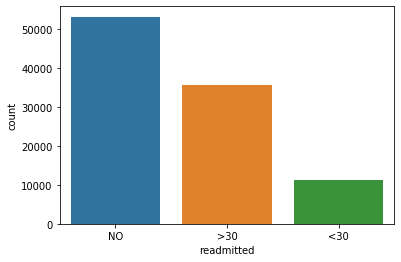

In [122]:
sns.countplot(y);

#### The classes are biased, so I'll need to keep that in mind going forward. I'll need to stratify and/or use SMOTE, etc.

In [123]:
list(df.select_dtypes(["number","bool_"]).columns)

['age',
 'weight',
 'time_in_hospital',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient',
 'number_diagnoses']

## Save with categoricals for fastai tabular learner

In [124]:
with open('y_2.pkl', 'wb') as picklefile:
    pickle.dump(y, picklefile)

with open('x_2_with_categoricals.pkl', 'wb') as picklefile:
    pickle.dump(df, picklefile)

## One hot encoding:

In [125]:
cat_cols = list(df.select_dtypes(exclude=["number","bool_"]).columns)
cat_cols

['race',
 'gender',
 'admission_type_id',
 'discharge_disposition_id',
 'admission_source_id',
 'payer_code',
 'medical_specialty',
 'diag_1',
 'diag_2',
 'diag_3',
 'max_glu_serum',
 'A1Cresult',
 'metformin',
 'repaglinide',
 'nateglinide',
 'chlorpropamide',
 'glimepiride',
 'acetohexamide',
 'glipizide',
 'glyburide',
 'tolbutamide',
 'pioglitazone',
 'rosiglitazone',
 'acarbose',
 'miglitol',
 'troglitazone',
 'tolazamide',
 'examide',
 'citoglipton',
 'insulin',
 'glyburide-metformin',
 'glipizide-metformin',
 'glimepiride-pioglitazone',
 'metformin-rosiglitazone',
 'metformin-pioglitazone',
 'change',
 'diabetesMed']

In [126]:
df_cat = pd.get_dummies(df[cat_cols],drop_first = True)
df = pd.concat([df.drop(cat_cols,axis=1),df_cat], axis = 1)

## Save one-hot encoded:

In [127]:
with open('x_2.pkl', 'wb') as picklefile:
    pickle.dump(df, picklefile)

## Quick test of model performance with this preprocessing

In [128]:
scaler = preprocessing.StandardScaler()

In [129]:
y = y.replace({'<30': 1, '>30': 0, 'NO': 0})
class_names = ["not early readmit", "early readmit"]

In [130]:
# stratified split
X_train, X_test, y_train, y_test = train_test_split(
    df, y, test_size=0.2, random_state=42, stratify=y)

In [131]:
# standard scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [132]:
# smote oversampling
smote = SMOTE()
X_train, y_train = smote.fit_sample(X_train, y_train)

In [133]:
model = ExtraTreesClassifier(n_estimators=100, n_jobs=-1, min_samples_split=25,
                             min_samples_leaf=35, max_features=150)

In [134]:
model.fit(X_train, y_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features=150, max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=35, min_samples_split=25,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [135]:
y_pred = model.predict(X_test)

y_pred_proba = model.predict_proba(X_test)

In [136]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.99      0.94     17752
           1       0.42      0.04      0.08      2271

    accuracy                           0.88     20023
   macro avg       0.66      0.52      0.51     20023
weighted avg       0.84      0.88      0.84     20023



In [137]:
def precision_recall_plot(y_test, y_pred_proba):
    p, r, t = precision_recall_curve(y_test, y_pred_proba[:, 1])

    # adding last threshold of '1' to threshold list
    t = np.vstack([t.reshape([-1, 1]), 1])
    
    # boxplot algorithm comparison
    fig = plt.figure(figsize=(10,10))
    fig.suptitle('Precision Recall Curve')
    ax = fig.add_subplot(111)
    plt.plot(t, p, label="precision")
    plt.plot(t, r, label="recall")
#     plt.show()

    return fig

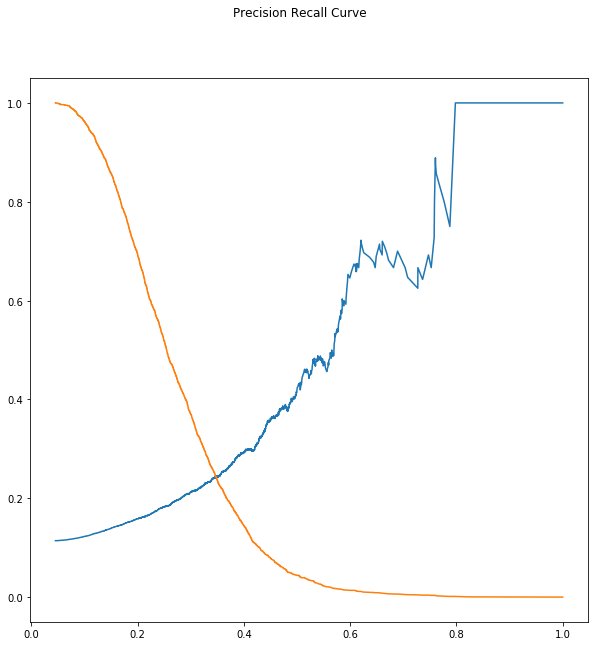

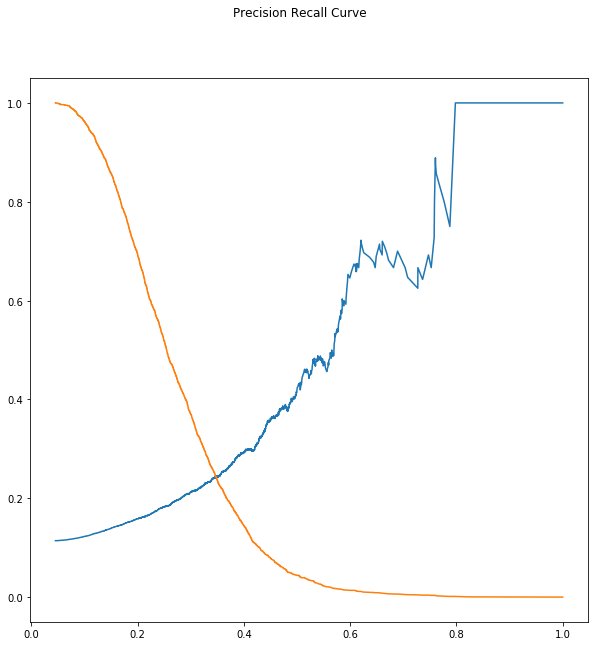

In [138]:
precision_recall_plot(y_test, y_pred_proba)

In [139]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=sns.color_palette("Blues")):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    ax = sns.heatmap(cm, cmap = cmap, annot=True, xticklabels=classes, yticklabels=classes)

    ax.set(title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the x labels and set their alignment
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Vertically center y labels
    plt.setp(ax.get_yticklabels(), va="center")
    
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    
    return ax

Confusion matrix, without normalization
[[17614   138]
 [ 2171   100]]


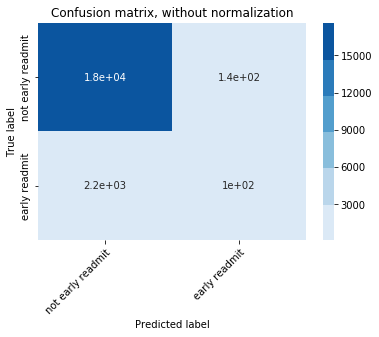

In [140]:
# Plot non-normalized confusion matrix
ax = plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# plt.savefig('confusion_matrix_test.png', bbox_inches="tight")